
Author: CFOLKERS <br>
Ministry, Division, Branch: WLRS, GEOBC, Geospatial Services<br>
Created Date: 2024/05/21 <br>
Updated Date: 
Description: quick script to create a buffered riparian dataset for KB CE <br>


In [1]:
import os
from getpass import getpass
import pandas
import geopandas as gpd
import logging
from bcgw2gdf import bcgw2gdf
#set up logging 
logging.basicConfig(level=logging.DEBUG)
debug=logging.debug
info=logging.info
warning=logging.warning
error=logging.error

In [ ]:
# local data
ev_boundary=r'boundaries/Misc_Boundaries.gdb'
ce_riparian=r"04_Final_Products/Final_Products_2015/RWCT/RWCT.gdb"

bcgw2gdf=bcgw2gdf()

In [6]:
bcgw2gdf.bcgw_connect()

DEBUG:root:oracle engine created


In [11]:
#query for layer in bounding box
q = """select * from WHSE_BASEMAPPING.FWA_LAKES_POLY where
SDO_ANYINTERACT (GEOMETRY,
	SDO_GEOMETRY(2003, 3005, NULL,
		SDO_ELEM_INFO_ARRAY(1,1003,3),
		SDO_ORDINATE_ARRAY(1671769,518070,1914369,682898) 
	)
) = 'TRUE'"""
lakes = bcgw2gdf.get_spatial_table(q)

INFO:root:spatial query returned as GeoDataFrame


In [25]:
q="""select * from WHSE_BASEMAPPING.FWA_STREAM_NETWORKS_SP where
SDO_ANYINTERACT (GEOMETRY,
	SDO_GEOMETRY(2003, 3005, NULL,
		SDO_ELEM_INFO_ARRAY(1,1003,3),
		SDO_ORDINATE_ARRAY(1671769,518070,1914369,682898) 
	)
) = 'TRUE'
"""
stream=bcgw2gdf.get_spatial_table(q)

INFO:root:spatial query returned as GeoDataFrame


In [33]:
q="""select * from WHSE_BASEMAPPING.FWA_WETLANDS_POLY where
SDO_ANYINTERACT (GEOMETRY,
	SDO_GEOMETRY(2003, 3005, NULL,
		SDO_ELEM_INFO_ARRAY(1,1003,3),
		SDO_ORDINATE_ARRAY(1671769,518070,1914369,682898) 
	)
) = 'TRUE'
"""
wetlands=bcgw2gdf.get_spatial_table(q)

INFO:root:spatial query returned as GeoDataFrame


In [ ]:
#load up Elk Valley Boundary 
ev=gpd.read_file(filename=ev_boundary, layer='Elk_Valley_Study_Area_2015')
#load up CE EV riparian layer
ev_rip=gpd.read_file(filename=ce_riparian,layer='riparian_area_lidar')
#make sure crs is 3005 and rename ev_rip geo col to wkt so it can be concated with oracle gdf
ev_rip = ev_rip.to_crs(3005)
ev_rip.rename(columns={'geometry':'wkt'}, inplace=True)

In [ ]:
#clip all layers from oracle to EV boundary
ev_lake= gpd.clip(lakes,ev)
ev_str= gpd.clip(stream,ev)
wetlands=gpd.clip(wetlands,ev)

In [90]:
#union polygons and lines
poly_union=gpd.GeoDataFrame(pandas.concat([ev_lake,wetlands]))
line_union=gpd.GeoDataFrame(pandas.concat([ev_str,ev_rip]))
#drop duplicate column 
line_union.drop(columns='SE_ANNO_CAD_DATA', inplace=True)


In [91]:
#buffer Polygons and lines 
poly_union['wkt']=poly_union.geometry.buffer(30)
line_union['wkt']=line_union.geometry.buffer(30)

In [96]:
#concat buffered gdfs
riparian_buffer=gpd.GeoDataFrame(pandas.concat([line_union,poly_union]))
#dissolve polygons
riparian_dissolve=riparian_buffer.dissolve()

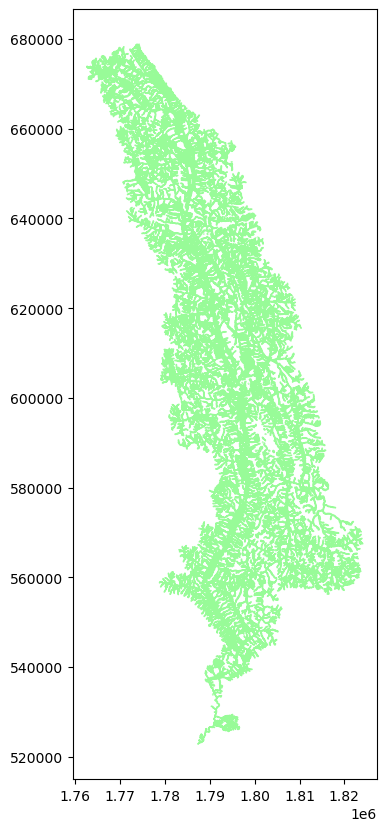

In [112]:
#plot for fun
ax = riparian_dissolve.plot(color="palegreen", edgecolor="palegreen", figsize=(20, 10))


In [ ]:
#export data
file_path = 'path/to/your/geodatabase.gdb'
layer_name = 'your_layer_name'

# lakes.to_file(file_path, layer=layer_name, driver='FileGDB')
lakes.to_parquet(os.path.join(file_path, layer_name))